# Introduction

In this notebook, we will walk through a case study, where an active learning strategy is employed to train a regression model adaptively. 

Active learning lets the model decide where in the parameter space it wants to learn next. By using only the necessary samples, an active learning strategy can effectively cut down the number of training samples, thus significantly reducing the computational burden of labeling training samples and improving the overall training efficiency.

In the current case study, the **Gaussian Process** is chosen as the target regression model, since this model type automatically estimates its prediction uncertainty (in the form of variance), thus permitting an esay implementation of the desired active learning strategy. 

To understand more about the intuition of the active learning approach, please check out the companion blog:

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

### Test Function

We select the following test function in this case study:

\begin{equation}
f(x) = 3(1-x)^2e^{(-x^2-1)}-10(0.2x-x^3)e^{-x^2}, \; x \in [-4, 1]
\end{equation}

Later on, we will train a Gaussian Process model to approximate this test function. To minimize the number of employed training samples, we will use an active learning strategy to intelligiently select one new sample at each learning iteration. Details of the active learning workflow is given in a latter section. 

For now, let's first plot this function to gain some intuition.

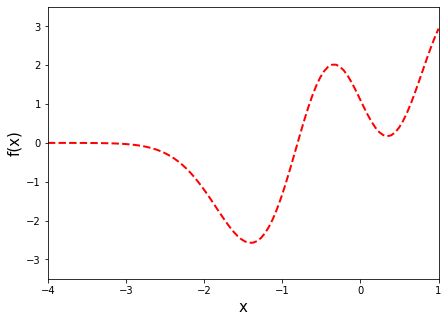

In [4]:
# Test function values
X_test = np.linspace(-4, 1, 100)
y_test = 3*(1-X_test)**2*np.exp(-X_test**2-1) \
            - 10*(0.2*X_test-X_test**3)*np.exp(-X_test**2)
            

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_xlim([-4,1]);
ax.set_ylim([-3.5,3.5]);
plt.savefig('./images/Test_function.png')

From the figure above, we can see that the current test function describes a rather complex relationship between the input $x$ and the output $f(x)$: a flat region exists in the range [-4, -3], while multimodal responses dominates the remaining region. Since the correlation length varies significantly across the parameter space, it is challenging to construct a globally accurate Gaussian Process model.

### Active learning strategy

To reduce the number of samples required in the training process, we adopt an active learning strategy to iteratively refine the Gaussian Process (GP) model. 

#### The Workflow

The general of the adopted active learning strategy consists of the following steps:

1. Train a model based on the currently available data;
2. Employ a *learning function* to decide the next sample to label;
3. Label the selected sample;
4.Enrich the current training dataset with the labeled sample;
5. Repeat steps 1–4 until the model reaches the target accuracy.

A visual illustration of the above steps is given below.

<img src="./images/Active_Learning.png" width=500 height=300 />

#### The Learning Function

Our goal is to strengthen the model at the place where it makes the largest prediction error. As a result, we want a learning function that can estimate the prediction errors of the unseen samples.

The prediction error can be defined as 

\begin{equation}
L(x) = (y(x)-M(x))^2,
\end{equation}

where $y(x)$ and $M(x)$ are the true function value and model prediction value for sample $x$, respectively. According to the **bias-variance decomposition**, the expected value of $L(x)$ can be written as 

\begin{equation}
E[L(x)] = \underbrace{y(x)-E[M(x)]}_{\text{bias}^2} + \underbrace{var[M(x)]}_{\text{variance}}
\end{equation}

However, computing $E[L(x)]$ is not straight-forward: although obtaining the variance value is easy (=model prediction variance), calculating the true bias value is simply impossible, as the true function output $y(x)$ is unknown. Therefore, we need to estimate the true bias value for an unseen sample $x$.

In this study, we use leave-one-out cross-validation error to estimate the prediction bias for an unseen sample $x^{\ast}$. Here are the steps:

